<a href="https://colab.research.google.com/github/RashmiChrystal/FYP/blob/main/FYP_Final_SmallDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection in Image Streams with Machine Learning**

The code has been changed to process the new dataset (big one) and the previous lines have been commented so pay attention to it.

# **Progress**

## Import Required Libraries

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.4 MB/s 
     |████████████████████████████████| 9.8 MB 27.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import math
import time
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from matplotlib import pyplot as plt
from skimage.feature import greycomatrix, greycoprops
import io
from math import sqrt

In [ ]:
start_time = time.time()

## Upload the Dataset from a local directory.

The dataset contains a series of images and a zipped folder is uploaded here.

In [ ]:
from google.colab import files
uploadedData = files.upload()

Saving smallDataset.zip to smallDataset.zip


The zipped dataset folder is unfolded and extracted using the following code.

In [ ]:
import zipfile
#data = zipfile.ZipFile(io.BytesIO(uploadedData['converted images.zip']), 'r')
#data = zipfile.ZipFile(io.BytesIO(uploadedData['Normal.zip']), 'r')
data = zipfile.ZipFile(io.BytesIO(uploadedData['smallDataset.zip']), 'r')
data.extractall()
#data.printdir()

The image data is read and stored in a list named list_3.

In [ ]:
list_3 = []
list_4 = []

filenames = glob.glob("smallDataset/"+"*.jpg")
#filenames = glob.glob("Normal/"+"*.jpg")
filenames.sort()
for img in filenames:
  n = cv2.imread(img, 0)
  if n is not None:
    list_3.append(n)
    list_4.append(img)
print("The length of the image dataset: ", len(list_3))

The length of the image dataset:  100


In [ ]:
anomaly_image = int(input("Input the number of the images for the training set: "))
dataset_length = len(list_3)

Input the number of the images for the training set: 43


## Preprocessing of the data

In [ ]:
crop_y = list_3[0].shape[0] - 40
crop_x = list_3[0].shape[1]

In [ ]:
def crop_image(img):  #crop_x, crop_y
  cropped_image = img[0:crop_y, 0:crop_x]
  return cropped_image

In [ ]:
from google.colab.patches import cv2_imshow

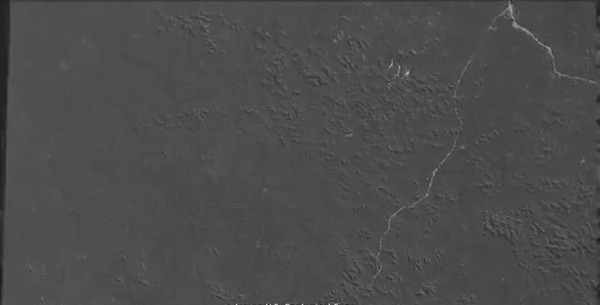

-1

In [ ]:
cropped_img = crop_image(list_3[0])
cv2_imshow(cropped_img)
cv2.waitKey(0)

Contrast Stretching is done on the images.

The equation of the contrast stretching function is as follows,


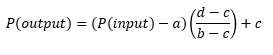

      where, P(output) = the value of the output pixel
      P(input) = the value of the input pixel
      a = lowest gray level value of the original image
    	b = highest gray level value of the original image
      c = lowest gray level value needed in the output image
      d = highest gray level value needed in the output image


In [ ]:
def contrastStretching(image):
    plt.hist(image.ravel(), 256, [0, 256])
    frame1 = image.copy()
    
    xp1 = [5, 50, 145, 250]
    fp1 = [5, 10, 245, 250]
    y = np.arange(256)
    table1 = np.interp(y, xp1, fp1).astype('uint8')
    frame1 = cv2.LUT(frame1, table1)
    plt.hist(frame1.ravel(), 256, [0, 256])
    #plt.show()
    return frame1

Noise removal is done by using the Gaussian Filter

The 2D isotropic Gaussian kernel,

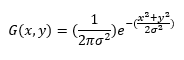

    where, G(x,y) = Gaussian distribution
	  σ = standard deviation


In [ ]:
def gaussianBlur(image):
    gaussian = cv2.GaussianBlur(image,(5,5),0)
    return gaussian

## Feature Extraction

Function to calculate the histogram of a given image. 

This will be needed for the calculation of the first-order statistical features.

In [ ]:
def calcHistogram(image):
    hist, edges, patches = plt.hist(image.ravel(), 256, [0, 256])
    return hist

Function to find the average of the calculated values for each pixel/pixel neighbourhoods of an image.

In [ ]:
def findAverage(list):
    avg = sum(list)/len(list)
    return avg

In [ ]:
#Extracting features
G = 256 #NUmber of gray levels in an image

### First-Order Statistical Features

Function to calculate the probability density value that will be needed for the first-order feature calculation.

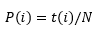

    where, P(i) = probability density of the intensity level, i
	  t(i) = the total number of pixels that has the intensity level, i
	  N = the total number of pixels in the image


In [ ]:
def calc_Probability_Density(hist_i_value, size):
    return (hist_i_value/size)

Statistical Mean calculation

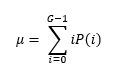

In [ ]:
def Stat_Mean(i, prob_density):
    mean = (i * (prob_density))
    return mean

Average COntrast calculation

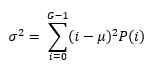

In [ ]:
def Stat_Avg_Contrast(i, prob_density, mean):
    avg_contrast = pow((i-mean),2) * prob_density
    return avg_contrast

Skewness of a pixel calculation

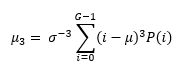

In [ ]:
def Stat_Skewness(i, mean, prob_density):
    skewness_component = pow((i-mean),3) * prob_density
    return skewness_component

Kurtosis of a pixel calculation

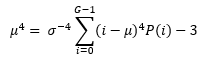

In [ ]:
def Stat_Kurtosis(i, mean, prob_density):
    kurtosis_component = (pow((i-mean),4) * prob_density) - 3
    return kurtosis_component

Energy of a pixel calculation

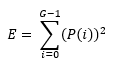

In [ ]:
def Stat_Energy(prob_density):
    energy = pow(prob_density,2)
    return energy

In [ ]:
#function for 4: contrast, skewness, kurtosis, energy
def Stat_Features_Set1(i, mean, prob_density):
    avg_contrast = pow((i - mean), 2) * prob_density
    skewness_component = pow((i - mean), 3) * prob_density
    kurtosis_component = (pow((i - mean), 4) * prob_density) - 3
    energy = pow(prob_density, 2)
    return avg_contrast, skewness_component, kurtosis_component, energy

In [ ]:
def calc_Stat_Features(img):
    Return_Set = []
    stat_mean=0
    stat_avg_contrast=0
    skewness_component=0
    kurtosis_component=0
    stat_energy=0
    hist = calcHistogram(img)
    size = img.size

    for i in range(G):
        p_d = calc_Probability_Density(hist[i], size)
        stat_mean += Stat_Mean(i, p_d)
        
    for i in range(G):
        p_d = calc_Probability_Density(hist[i], size)
        p1, p2, p3, p4 = Stat_Features_Set1(i, stat_mean, p_d)
        stat_avg_contrast += p1  # variance^2 (avg_contrast)
        skewness_component += p2 #skewness_component
        kurtosis_component += p3 #kurtosis_component
        stat_energy += p4 #energy

    skewness = pow(stat_avg_contrast,(-3/2)) * skewness_component
    kurtosis = pow(stat_avg_contrast,(-4/2)) * kurtosis_component
    return stat_mean, stat_avg_contrast, skewness, kurtosis, stat_energy

### Gabor Wavelet Feature Extraction

The Gabor function used,

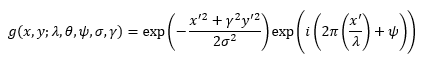

    where, x^'=xcos⁡θ + ysin⁡θ
	  y^'=-xsin⁡θ + ycos⁡θ
	  λ=wavelength of the sine component
	  θ=orientation of the parallel lines formed by the kernel
	  ψ=phase offset
	  σ=standard deviation of the gaussian envelope
	  ϒ=aspect ratio


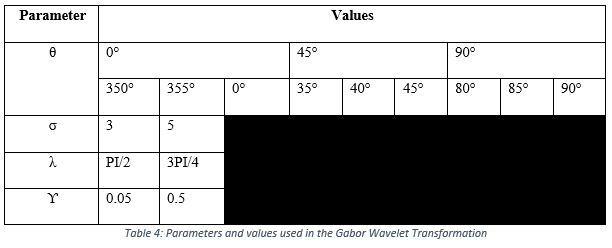

In [ ]:
def gaborFilter(img):
    num = 1
    fimg_list = []
    for theta in range(3):  # 0, 45, 90
        theta = theta / 4 * np.pi  # theta 0, 1/4, 1/2 => 0, 45, 90
        for theta_i in (theta - 10, theta - 5, theta):
            for sigma in (3, 5):
                for lamda in np.arange(np.pi / 2, np.pi, np.pi / 4):
                    for gamma in (0.05, 0.5):
                        gabor_label = 'Gabor' + str(num)
                        kernel = cv2.getGaborKernel((5, 5), sigma, theta_i, lamda, gamma, 0,
                                                    ktype=cv2.CV_32F)  
                        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                        filtered_img = fimg.reshape(-1)
                  
                        fimg_list.append(fimg)
                        
                        num += 1
    return fimg_list

    # ktype is the data type. so it's saying that after the kernel is generated, store it as 32 float
                       

### Edge Detected Features

In [ ]:
def cannyEdge(img):
    edges = cv2.Canny(img, 100, 200)
    edges2 = edges.reshape(-1)
    return edges2

In [ ]:
def edge_roberts(img):
    edge_robert = roberts(img)
    edge_robert2 = edge_robert.reshape(-1)
    return edge_robert2

In [ ]:
def edge_sobel(img):
    edge_sobel1 = sobel(img)
    edge_sobel2 = edge_sobel1.reshape(-1)
    return edge_sobel2

In [ ]:
def edge_scharr(img):
    edge_scharr1 = scharr(img)
    edge_scharr2 = edge_scharr1.reshape(-1)
    return edge_scharr2

In [ ]:
def edge_prewitt(img):
    edge_prewitt1 = prewitt(img)
    edge_prewitt2 = edge_prewitt1.reshape(-1)
    return edge_prewitt2

### Other extracted features: Gaussian S3 and S7, Entropy features

In [ ]:
def gaussianFeature(img):
    gaussian_img = nd.gaussian_filter(img, sigma = 3) #Gaussian S3
    gaussian_img1 = gaussian_img.reshape(-1)
    gaussian_img2 = nd.gaussian_filter(img, sigma=7) #Gaussian S7
    gaussian_img3 = gaussian_img2.reshape(-1)
    return gaussian_img1, gaussian_img3

In [ ]:
def entropyFeature(img):
    entropy_img = entropy(img, disk(1))
    entropy_img1 = entropy_img.reshape(-1)
    return entropy_img1

### GLCM Feature Extraction

In [ ]:
def glcmFeatures(img):
    glcm = greycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    diss_sim = greycoprops(glcm, 'dissimilarity')[0, 0] # [0,0] to convert array to value
    corr = greycoprops(glcm, 'correlation')[0, 0]
    homogen = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    return diss_sim, corr, homogen, energy, contrast

### Preparing for Feature extraction

Defining the lists needed to store the calculated features for each image.

In [ ]:
contrast_stretched_image_list = []
num_CS = 0
Canny_Edges_list = []
Edge_Roberts_List = []
Edge_Sobel_List = []
Edge_Scharr_List = []
Edge_Prewitt_List = []
Gaussian_img1_List = []
Gaussian_img3_List = []
Variance_list = []
Stat_Mean_List = []
Stat_Avg_Contrast_List = []
Stat_Skewness_List = []
Stat_Kurtosis_List = []
Stat_Energy_List = []
Stat_Entropy_List = []
Gabor_Individual_List = []
GLCM_diss_sim_List = []
GLCM_corr_List = []
GLCM_homogen_List = []
GLCM_energy_List = []
GLCM_contrast_List = []

In [ ]:
df = pd.DataFrame()
#df_sift = pd.DataFrame()
df_newFeatures1 = pd.DataFrame()

### Feature Extraction

In [ ]:
prep_and_extract_start_time = time.time()

Extracting features for each image from the dataset.

length of images list,  100
0
length of images list,  100
1
length of images list,  100
2
length of images list,  100
3
length of images list,  100
4
length of images list,  100
5
length of images list,  100
6
length of images list,  100
7
length of images list,  100
8
length of images list,  100
9
length of images list,  100
10
length of images list,  100
11
length of images list,  100
12
length of images list,  100
13
length of images list,  100
14
length of images list,  100
15
length of images list,  100
16
length of images list,  100
17
length of images list,  100
18
length of images list,  100
19
length of images list,  100
20
length of images list,  100
21
length of images list,  100
22
length of images list,  100
23
length of images list,  100
24
length of images list,  100
25
length of images list,  100
26
length of images list,  100
27
length of images list,  100
28
length of images list,  100
29
length of images list,  100
30
length of images list,  100
31
length of images l

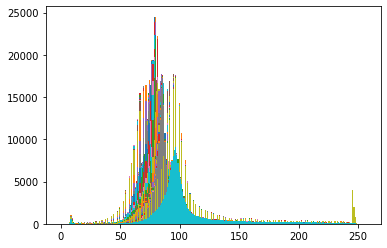

In [ ]:
for img in list_3:
  print("length of images list, ", len(list_3))
  cropped_img = crop_image(img)
  CS_img = contrastStretching(cropped_img)
  contrast_stretched_image_list.append(CS_img)
  gaussian_img = gaussianBlur(CS_img)

  canny_edges2 = cannyEdge(gaussian_img)
  avg_canny_edges2 = findAverage(canny_edges2)
  Canny_Edges_list.append(avg_canny_edges2)

  edge_robert2 = edge_roberts(gaussian_img)
  avg_edge_roberts2 = findAverage(edge_robert2)
  Edge_Roberts_List.append(avg_edge_roberts2)

  edge_sobel2 = edge_sobel(gaussian_img)
  avg_edge_sobel2 = findAverage(edge_sobel2)
  Edge_Sobel_List.append(avg_edge_sobel2)

  edge_scharr2 = edge_scharr(gaussian_img)
  avg_edge_scharr2 = findAverage(edge_scharr2)
  Edge_Scharr_List.append(avg_edge_scharr2)

  edge_prewitt2 = edge_prewitt(gaussian_img)
  avg_edge_prewitt2 = findAverage(edge_prewitt2)
  Edge_Prewitt_List.append(avg_edge_prewitt2)

  gaussian_img1, gaussian_img3 = gaussianFeature(gaussian_img)
  avg_gaussian_img1 = findAverage(gaussian_img1)
  avg_gaussian_img3 = findAverage(gaussian_img3)
  Gaussian_img1_List.append(avg_gaussian_img1)
  Gaussian_img3_List.append(avg_gaussian_img3)

  entropy_img1 = entropyFeature(gaussian_img)
  avg_entropy_img1 = findAverage(entropy_img1)
  Variance_list.append(avg_entropy_img1)

  gabor_images = gaborFilter(gaussian_img)
  total_gabor_image_values = [] #42 elements
  for img in gabor_images:
    g = img.reshape(-1)
    avg_g = findAverage(g)
    total_gabor_image_values.append(avg_g)
  
  Gabor_Individual_List.append(total_gabor_image_values)

  stat_mean, stat_avg_contrast, skewness, kurtosis, stat_energy = calc_Stat_Features(gaussian_img)
  Stat_Mean_List.append(stat_mean)
  Stat_Avg_Contrast_List .append(stat_avg_contrast)
  Stat_Skewness_List.append(skewness)
  Stat_Kurtosis_List.append(kurtosis)
  Stat_Energy_List.append(stat_energy)

  diss_sim, corr, homogen, energy, contrast = glcmFeatures(gaussian_img)
  GLCM_diss_sim_List.append(diss_sim)
  GLCM_corr_List.append(corr)
  GLCM_homogen_List.append(homogen)
  GLCM_energy_List.append(energy)
  GLCM_contrast_List.append(contrast)

  print(num_CS)
  num_CS = num_CS + 1
  

In [ ]:
Gabor_Total_Dict = {}
for i in range(len(Gabor_Individual_List[0])):
  Gabor_Total_Dict['GB'+str(i)]=[]

for i in Gabor_Individual_List:
  image_values = i
  num = 0
  for j in image_values:
    label = 'GB'+str(num)
    val = Gabor_Total_Dict[label]
    val.append(j)
    Gabor_Total_Dict[label] = val
    num += 1

print("Length of the Gabor dictionary", len(Gabor_Total_Dict))
Gray_Images_List = []
for i in range(len(list_3)):
  Gray_Images_List.append(i+1)

Length of the Gabor dictionary 72


In [ ]:
prep_and_extract_end_time = time.time()

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


### Putting the extracted feature data into a Pandas Dataframe.

In [ ]:
df_newFeatures1['Gray Level Images'] = Gray_Images_List
df_newFeatures1['CannyEdge'] = Canny_Edges_list
df_newFeatures1['EdgeRoberts'] = Edge_Roberts_List
df_newFeatures1['EdgeSobel'] = Edge_Sobel_List
df_newFeatures1['EdgeScharr'] = Edge_Scharr_List
df_newFeatures1['EdgePrewitt'] = Edge_Prewitt_List
df_newFeatures1['StatMean'] = Stat_Mean_List
df_newFeatures1['StatAvgContrast'] = Stat_Avg_Contrast_List
df_newFeatures1['StatSkewness'] = Stat_Skewness_List
df_newFeatures1['StatKurtosis'] = Stat_Kurtosis_List
df_newFeatures1['StatEnergy'] = Stat_Energy_List
# df_newFeatures1['StatEntropy'] = Stat_Entropy_List
df_newFeatures1['Gaussian1'] = Gaussian_img1_List
df_newFeatures1['Gaussian3'] = Gaussian_img3_List
df_newFeatures1['Entropy'] = Variance_list

Gabor_num = 0
for i in range(len(Gabor_Total_Dict)):
  label = 'GB' + str(Gabor_num)
  val = Gabor_Total_Dict[label]
  df_newFeatures1[label] = val
  Gabor_num += 1

df_newFeatures1['GLCM_Diss_similarity'] = GLCM_diss_sim_List
df_newFeatures1['GLCM_Correlation'] = GLCM_corr_List
df_newFeatures1['GLCM_Homogeneity'] = GLCM_homogen_List
df_newFeatures1['GLCM_Energy'] = GLCM_energy_List
df_newFeatures1['GLCM_Contrast'] = GLCM_contrast_List

print(df_newFeatures1.head())

df_newFeatures1.to_csv('drive/MyDrive/UOM/FYP/Features.csv')
print("end")

   Gray Level Images  CannyEdge  EdgeRoberts  EdgeSobel  EdgeScharr  \
0                  1   2.537459     0.011309   0.014346    0.014518   
1                  2   2.579262     0.011708   0.014832    0.015012   
2                  3   2.601557     0.012066   0.015256    0.015443   
3                  4   2.791066     0.012368   0.015611    0.015805   
4                  5   2.905328     0.012664   0.015993    0.016191   

   EdgePrewitt   StatMean  StatAvgContrast  StatSkewness  StatKurtosis  ...  \
0     0.014135  74.175831       132.325690     -0.774150     18.506526  ...   
1     0.014611  73.879257       128.926448     -0.720539     18.189140  ...   
2     0.015024  73.696967       128.506220     -0.616772     17.369104  ...   
3     0.015372  73.637388       125.023103     -0.509124     17.467100  ...   
4     0.015748  73.574678       125.812358     -0.406448     17.047392  ...   

        GB67  GB68  GB69        GB70        GB71  GLCM_Diss_similarity  \
0  89.975891   0.0   0.0

### Plotting the Feature data

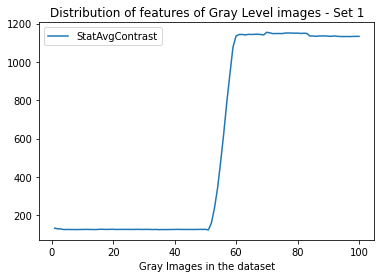

In [ ]:
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatAvgContrast'], label="StatAvgContrast")
plt.xlabel('Gray Images in the dataset')
plt.title('Distribution of features of Gray Level images - Set 1')
plt.legend()
plt.show()

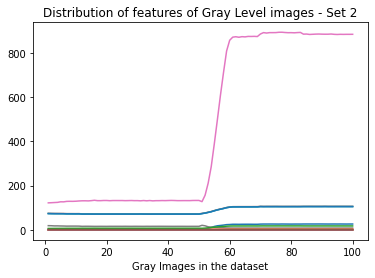

In [ ]:
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['CannyEdge'], label="CannyEdge")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['EdgeRoberts'], label="EdgeRoberts")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['EdgeSobel'], label="EdgeSobel")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['EdgeScharr'], label="EdgeScharr")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['EdgePrewitt'], label="EdgePrewitt")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatMean'], label="StatMean")
    #plt.plot(features['Gray Level Images'], features['StatAvgContrast'], label="StatAvgContrast")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatSkewness'], label="StatSkewness")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatKurtosis'], label="StatKurtosis")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatEnergy'], label="StatEnergy")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['Gaussian1'], label="Gaussian1")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['Gaussian3'], label="Gaussian3")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['Entropy'], label="Entropy")

plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Diss_similarity'], label="GLCM_Diss_similarity")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Correlation'], label="GLCM_Correlation")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Homogeneity'], label="GLCM_Homogeneity")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Energy'], label="GLCM_Energy")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Contrast'], label="GLCM_Contrast")
plt.xlabel('Gray Images in the dataset')
plt.title('Distribution of features of Gray Level images - Set 2')
# plt.legend()
plt.show()


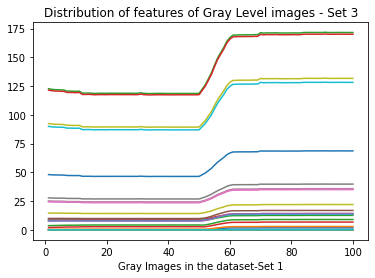

In [ ]:
Gabor_plot_label_i = 0
for i in range(31):
  Gabor_plot_label = 'GB' + str(i)
  plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1[Gabor_plot_label], label=Gabor_plot_label)
  Gabor_plot_label_i += 1

plt.xlabel('Gray Images in the dataset-Set 1')
plt.title('Distribution of features of Gray Level images - Set 3')
# plt.legend()
plt.show()

## Performing Principal Component Analysis for Dimensionlity Reduction.

In [ ]:
pca_start_time = time.time()

In [ ]:
#Standardize the data (The first step of PCA)

def standardizeData(featureset):
  X_std = StandardScaler().fit_transform(featureset)
  print(X_std.shape)
  return X_std

In [ ]:
def getCovarianceMatrix(X_std):
   mean_vec= np.mean(X_std, axis=0)
   cov_mat = (X_std - mean_vec).T.dot((X_std-mean_vec)) / (X_std.shape[0]-1)
   print('Covariance matrix: \n%s' %cov_mat)
   return cov_mat

In [ ]:
def performPCA():
    featureset = df_newFeatures1
    featureset.drop(['Gray Level Images'], axis = 1, inplace = True)

    X_std = standardizeData(featureset)
    cov_mat = getCovarianceMatrix(X_std)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    pca = sklearnPCA(n_components=2)
    pca.fit_transform(featureset)
    print('PCA Variance ratio: ', pca.explained_variance_ratio_)
    principalComponents_features = pca.fit_transform(X_std)
    principal_features = pd.DataFrame(data=principalComponents_features, columns=['principal component 1', 
                                                                                  'principal component 2'])
    principal_features.to_csv('drive/MyDrive/UOM/FYP/PCAFeatures.csv')

    pca = sklearnPCA().fit(X_std)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

    return principal_features

    # x = []
    # y = principal_features['principal component 1']
    # for i in range(len(list_3)):
    #     x.append(i)
    # plt.plot(x,y)
    # plt.xlabel('number of images')
    # plt.ylabel('PCA1')
    # plt.show()

    # y_pca2 = principal_features['principal component 2']
    # plt.plot(x, y_pca2)
    # plt.xlabel('number of images')
    # plt.ylabel('PCA2')
    # plt.show()


(100, 90)
Covariance matrix: 
[[ 1.01010101  1.00808365  1.00848487 ... -0.90132126 -0.89210041
   1.00798057]
 [ 1.00808365  1.01010101  1.01003632 ... -0.92266898 -0.91217648
   1.00857425]
 [ 1.00848487  1.01003632  1.01010101 ... -0.92055256 -0.91063033
   1.00875316]
 ...
 [-0.90132126 -0.92266898 -0.92055256 ...  1.01010101  0.99872989
  -0.90245052]
 [-0.89210041 -0.91217648 -0.91063033 ...  0.99872989  1.01010101
  -0.89384821]
 [ 1.00798057  1.00857425  1.00875316 ... -0.90245052 -0.89384821
   1.01010101]]
PCA Variance ratio:  [9.99847594e-01 8.29014324e-05]


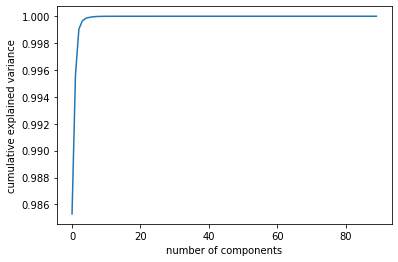

In [ ]:
principal_features = performPCA()

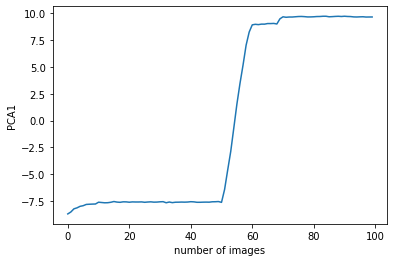

In [ ]:
x = []
y = principal_features['principal component 1']
for i in range(len(list_3)):
  x.append(i)
plt.plot(x,y)
plt.xlabel('number of images')
plt.ylabel('PCA1')
plt.show()

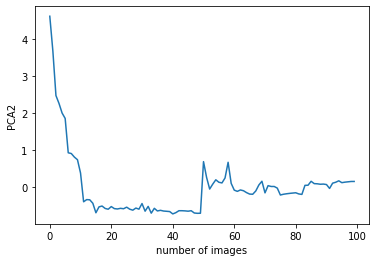

In [ ]:
y_pca2 = principal_features['principal component 2']
plt.plot(x, y_pca2)
plt.xlabel('number of images')
plt.ylabel('PCA2')
plt.show()

In [ ]:
pca_end_time = time.time()

## ARIMA

### Reading and splitting the dataset

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/UOM/FYP/PCAFeatures.csv')
print(file)

    Unnamed: 0  principal component 1  principal component 2
0            0              -8.706064               4.622653
1            1              -8.524433               3.681433
2            2              -8.230911               2.479771
3            3              -8.139457               2.265752
4            4              -7.997078               2.008008
..         ...                    ...                    ...
95          95               9.686120               0.126029
96          96               9.694437               0.139778
97          97               9.667757               0.148907
98          98               9.672181               0.158050
99          99               9.673754               0.158838

[100 rows x 3 columns]


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
PCA1 = file["principal component 1"] 
print(PCA1)

0    -8.706064
1    -8.524433
2    -8.230911
3    -8.139457
4    -7.997078
        ...   
95    9.686120
96    9.694437
97    9.667757
98    9.672181
99    9.673754
Name: principal component 1, Length: 100, dtype: float64


In [ ]:
train, test = PCA1[0:anomaly_image], PCA1[anomaly_image:len(PCA1)]

print(train.head(5))
print(test.head(5))

0   -8.706064
1   -8.524433
2   -8.230911
3   -8.139457
4   -7.997078
Name: principal component 1, dtype: float64
43   -7.620011
44   -7.609040
45   -7.604194
46   -7.609484
47   -7.574157
Name: principal component 1, dtype: float64


In [ ]:
print(train.values) #PCA1
X = train.values

[-8.7060642  -8.52443287 -8.23091129 -8.13945697 -7.99707811 -7.93947655
 -7.82080416 -7.80277582 -7.78915757 -7.78157399 -7.61385604 -7.64140304
 -7.66807708 -7.65981754 -7.61901454 -7.54976684 -7.60219975 -7.62312293
 -7.57803988 -7.58310237 -7.61454177 -7.58524418 -7.59341721 -7.59338392
 -7.58475129 -7.6204214  -7.59588677 -7.5787978  -7.60825023 -7.60123982
 -7.57582808 -7.56374061 -7.66436501 -7.59632351 -7.65288929 -7.61429498
 -7.61089888 -7.59992544 -7.60807365 -7.59745316 -7.56620686 -7.58039578
 -7.62001064]


### ARIMA model training

In [ ]:
from pmdarima.arima import auto_arima

COnsider PACF plot -> there is a cutoff shown, so the p value is 1.
COnsider ACF plot -> this shows a dieout so the q value is 0.
The number of differences (d) was found using the ADF test earlier and d=0

In [ ]:
arima_start_time = time.time()

In [ ]:
arima_result = auto_arima(train)
print(arima_result)
print("\n")
print(arima_result.summary())

 ARIMA(1,2,2)(0,0,0)[0]          


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:               SARIMAX(1, 2, 2)   Log Likelihood                  60.666
Date:                Sun, 17 Apr 2022   AIC                           -113.333
Time:                        18:24:04   BIC                           -106.479
Sample:                             0   HQIC                          -110.837
                                 - 43                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6083      0.168      3.626      0.000       0.280       0.937
ma.L1         -1.6366      0.646     -2.535      0.011      -2.902      -0.371
ma.L2          0

In [ ]:
result_string = str(arima_result)
number_of_diffs = int(result_string[9])
print(number_of_diffs)
print(type(number_of_diffs))

2
<class 'int'>


In [ ]:
arima_end_time = time.time()

### Plotting Residuals

In [ ]:
residuals = pd.DataFrame(arima_result.resid())

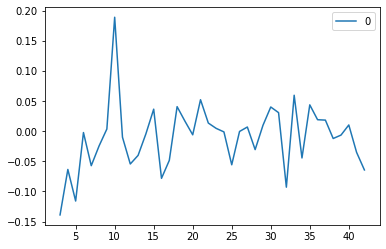

In [ ]:
residuals[(number_of_diffs+1):].plot()
plt.show()

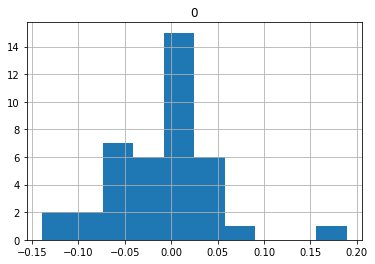

In [ ]:
residuals[(number_of_diffs+1):].hist()
plt.show()

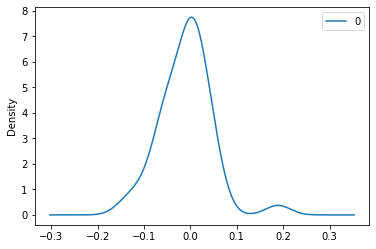

In [ ]:
residuals[(number_of_diffs+1):].plot(kind='kde')
plt.show()

In [ ]:
from statsmodels.graphics.gofplots import qqplot

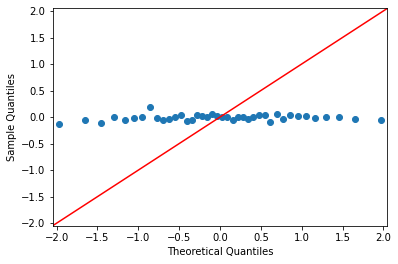

In [ ]:
qqplot(residuals[(number_of_diffs+1):], line='45')
plt.show()

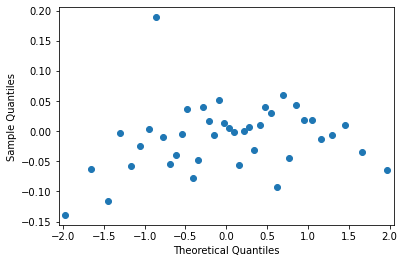

In [ ]:
qqplot(residuals[(number_of_diffs+1):])
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

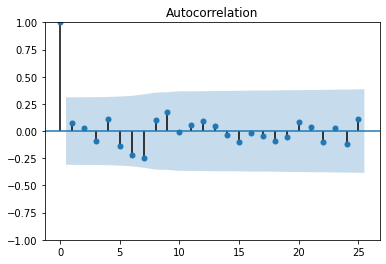

In [ ]:
plot_acf(residuals[(number_of_diffs+1):], lags=25)
plt.show()

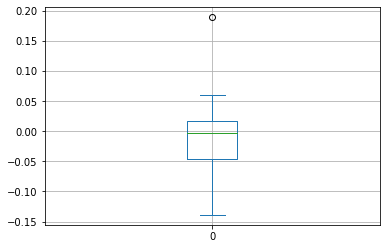

In [ ]:
residuals[(number_of_diffs+1):].plot.box(grid='True')

### Residual Description

In [ ]:
residuals_description = residuals[(number_of_diffs+1):].describe()
df_residuals_description = pd.DataFrame(residuals_description)
df_residuals_description

,0
count,40.000000
mean,-0.009914
std,0.055719
min,-0.139013
25%,-0.045539
50%,-0.003467
75%,0.017002
max,0.188893


In [ ]:
min = float(df_residuals_description.loc["25%"]) - 1.5 * (float(df_residuals_description.loc["75%"])-float(df_residuals_description.loc["25%"])) #
max = float(df_residuals_description.loc["75%"]) + 1.5 * (float(df_residuals_description.loc["75%"])-float(df_residuals_description.loc["25%"]))
print(min)
print(max)

-0.13935099564338116
0.11081440987631042


In [ ]:
from statsmodels.tsa.stattools import acf #i dont think we need this here

## Forecasting

In [ ]:
forecast_start_time = time.time()

In [ ]:
test_length = len(PCA1) - len(train)
print(test_length)

57


In [ ]:
forecast = arima_result.predict(test_length, alpha=0.05) # 95% conf
print(forecast)

[ -7.60473956  -7.61739908  -7.64704849  -7.68703268  -7.73330339
  -7.78339814  -7.835819    -7.88965482  -7.94435134  -7.99957141
  -8.05510996  -8.11084223  -8.16669234  -8.22261413  -8.27857952
  -8.33457144  -8.39057948  -8.44659735  -8.50262118  -8.55864865
  -8.61467832  -8.67070934  -8.72674117  -8.78277351  -8.83880614
  -8.89483896  -8.95087189  -9.00690489  -9.06293793  -9.11897099
  -9.17500407  -9.23103716  -9.28707026  -9.34310336  -9.39913646
  -9.45516956  -9.51120266  -9.56723577  -9.62326887  -9.67930197
  -9.73533508  -9.79136818  -9.84740128  -9.90343439  -9.95946749
 -10.0155006  -10.0715337  -10.1275668  -10.18359991 -10.23963301
 -10.29566612 -10.35169922 -10.40773233 -10.46376543 -10.51979853
 -10.57583164 -10.63186474]


In [ ]:
# Make it a pandas series
fc_series = pd.Series(forecast, index=test.index)

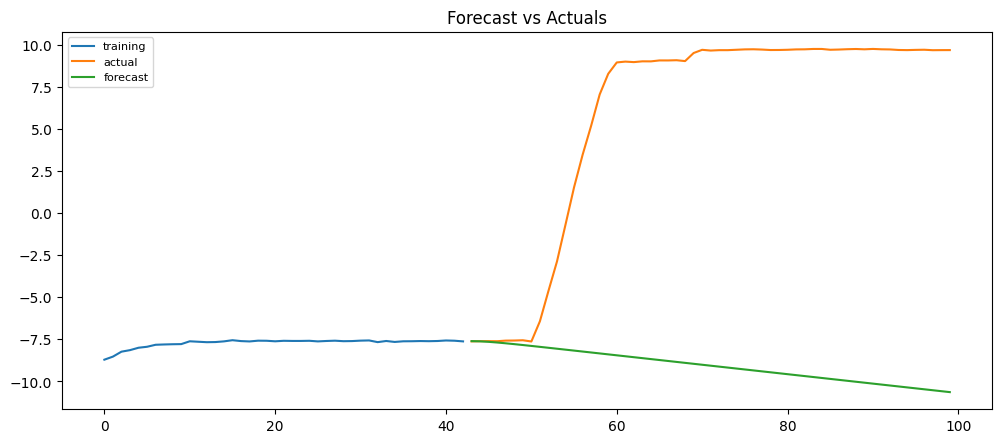

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
forecast_end_time = time.time()

## Binary Classification

In [ ]:
classification_start_time = time.time()

Calculating the forecast errors using the forecasted series and the actual values of the test series

In [ ]:
y_hat_values = []
i = len(train)
print(i)
for value in fc_series:
  y_hat = test[i] - value
  #print("test val: ", test[i], " - forecasted value: ", value , " = ", "y_hat: ",y_hat)
  y_hat_values.append(y_hat)
  i = i + 1

df_Forecasted_Series = pd.DataFrame(np.array(y_hat_values).astype(np.float), index = range(anomaly_image, len(PCA1)), columns = ['Forecasted_Error'])
df_Forecasted_Series

43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


,Forecasted_Error
43,-0.015271
44,0.008359
45,0.042854
46,0.077549
47,0.159146
48,0.214779
49,0.283466
50,0.263032
51,1.518479
52,3.373028


In [ ]:
index = df_Forecasted_Series.index
for i in index:
    error = df_Forecasted_Series["Forecasted_Error"].loc[i]
    #Classify residuals as normal/anomaly
    if (error>max):
      df_Forecasted_Series.loc[i, 'Predicted_Class'] = "Anomaly"
    else:
      df_Forecasted_Series.loc[i, 'Predicted_Class'] = "Normal"

    #Set the actual class
    if(i>=51):
      df_Forecasted_Series.loc[i, 'Actual_Class'] = "Anomaly"
    else:
      df_Forecasted_Series.loc[i, 'Actual_Class'] = "Normal"

In [ ]:
df_Forecasted_Series

,Forecasted_Error,Predicted_Class,Actual_Class
43,-0.015271,Normal,Normal
44,0.008359,Normal,Normal
45,0.042854,Normal,Normal
46,0.077549,Normal,Normal
47,0.159146,Anomaly,Normal
48,0.214779,Anomaly,Normal
49,0.283466,Anomaly,Normal
50,0.263032,Anomaly,Normal
51,1.518479,Anomaly,Anomaly
52,3.373028,Anomaly,Anomaly


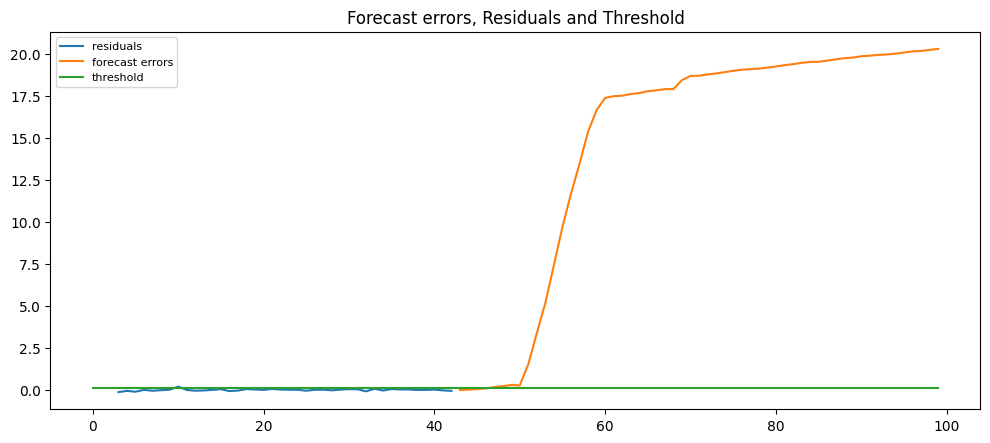

In [ ]:
max_threshold_series = np.full((100,1), max)
forecast_error_series = df_Forecasted_Series["Forecasted_Error"]
plt.figure(figsize=(12,5), dpi=100)
plt.plot(residuals[(number_of_diffs+1):], label='residuals')
plt.plot(forecast_error_series, label='forecast errors')
plt.plot(max_threshold_series, label='threshold')
plt.title('Forecast errors, Residuals and Threshold')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
classification_end_time = time.time()

In [ ]:
end_time = time.time()

## Measuring Performance

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
confusionMatrix = confusion_matrix(df_Forecasted_Series['Actual_Class'], df_Forecasted_Series['Predicted_Class'])
confusionMatrix

array([[49,  0],
       [ 4,  4]])

Text(0.5, 1.0, 'Confusion Matrix')

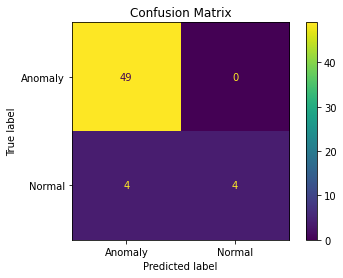

In [ ]:
cmd = ConfusionMatrixDisplay(confusionMatrix, display_labels=['Anomaly' ,'Normal'])
cmd.plot()
plt.title('Confusion Matrix')

In [ ]:
import seaborn as sn

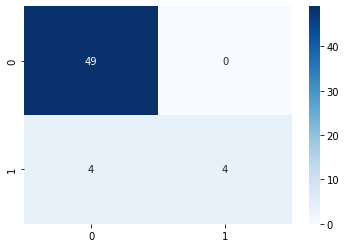

In [ ]:
sn.heatmap(confusionMatrix, annot=True, cmap='Blues')

It is important to note that, 


> our objective function = finding an anomaly

So, the positive class should favour it.


> Positive class = anomaly behaviour (0)


> Negative class = normal behaviour (1)








> ▶True positives => True label:Anomaly, Predicted label:Anomaly [0,0]


> ▶True negatives => True label:Normal, Predicted label:Normal [1,1]


> ▶False positives => True label:Normal, Predicted label:Anomaly [1,0]


> ▶False negatives => True label:Anomaly, Predicted label:Normal [0,1]

Original example for ravel() was,


> TN,FP,FN,TP = confusionmatrix.ravel()



In [ ]:
True_positives,False_negatives,False_positives,True_negatives = confusionMatrix.ravel()
print("True positives: ", True_positives)
print("True negatives: ", True_negatives)
print("False positives: ", False_positives)
print("False negatives: ", False_negatives)

True positives:  49
True negatives:  4
False positives:  4
False negatives:  0


In [ ]:
accuracy = (True_positives+True_negatives)/(True_positives+True_negatives+False_positives+False_negatives)
accuracy

0.9298245614035088

In [ ]:
sensitivity = True_positives/(True_positives+False_negatives) #Sn
sensitivity

1.0

In [ ]:
specificity = True_negatives/(True_negatives+False_positives) #Sp
specificity

0.5

In [ ]:
positive_predictive_value = True_positives/(True_positives+False_positives)
positive_predictive_value

0.9245283018867925

In [ ]:
negative_predictive_value = True_negatives/(True_negatives+False_negatives)
negative_predictive_value

1.0

In [ ]:
precision = (True_positives+True_negatives)/(True_positives+True_negatives+False_positives+False_negatives)
precision

0.9298245614035088

In [ ]:
cc_numerator = True_positives*True_negatives - False_positives*False_negatives
cc_denominator = math.sqrt(51*(True_positives+False_positives)*((100-anomaly_image)-51)*(True_negatives+False_negatives))
corr_coefficient = cc_numerator/cc_denominator
corr_coefficient

0.7695333174715243

In [ ]:
relationship_index = abs(specificity-sensitivity)/(specificity+sensitivity)
relationship_index

0.3333333333333333

In [ ]:
P = specificity*(49/len(test)) + sensitivity*((len(test) - 49)/len(test))
OP = P-relationship_index
OP

0.2368421052631579

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
MSE = mean_squared_error(test, fc_series)
 
RMSE = math.sqrt(MSE)
print(RMSE)

16.550320258462136


## Time Taken

Total time taken for the small dataset **(in seconds)**

In [ ]:
total_time = end_time - start_time
total_time

1116.825960636139

Time taken for the pre-processing and feature extraction **(in seconds)**

In [ ]:
time_prep_and_extract = prep_and_extract_end_time - prep_and_extract_start_time
time_prep_and_extract

408.30091524124146

Time taken for the PCA **(in seconds)**

In [ ]:
time_PCA = pca_end_time - pca_start_time
time_PCA

12.045389890670776

Time taken for ARIMA **(in seconds)**

In [ ]:
time_arima = arima_end_time - arima_start_time
time_arima

2.265552043914795

Time taken for forecasting **(in seconds)**

In [ ]:
time_forecast = forecast_end_time - forecast_start_time
time_forecast

0.2878913879394531

Time taken for the binary classification **(in seconds)**

In [ ]:
time_classification = classification_end_time - classification_start_time
time_classification

0.3554697036743164

## Classification with EVT

### Import necessary libraries

In [ ]:
!pip install fitter

     |████████████████████████████████| 47 kB 3.3 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25026 sha256=a6c75fb284d379607c822d1d189f1d4b235a5dd8df2f76a518e5651b05bf839b
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=6933b4691ba15399e1a56c248ecca2fe3ccb35fb359ca4cd04b70211c31063a9
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


In [ ]:
from fitter import Fitter
from scipy.stats import gumbel_l

In [ ]:
evt_start_time = time.time()

### Threshold calculation using EVT

In [ ]:
def anomaly_threshold_evt(residuals, confidence):
  #transforming the residuals
  extrem_prob_residuals = np.exp(-np.exp(-residuals)) 
  f1 = Fitter(extrem_prob_residuals, distributions=['gumbel_l'], bins=45)
  #fitting to the curve
  f1.fit()
  params = f1.get_best()
  t = gumbel_l.ppf(confidence, loc=params.get("gumbel_l").get("loc"), scale=params.get("gumbel_l").get("scale"))
  #retransform
  threshold_val = np.log(-np.log(t))   
  return threshold_val

In [ ]:
evt_threshold = anomaly_threshold_evt(np.array(residuals[(number_of_diffs+1):]), 0.05)

In [ ]:
evt_threshold

0.18828422713021598

In [ ]:
def classifyData(threshold, df):
  index = df.index
  for i in index:
    error = df["Forecasted_Error"].loc[i]
    #Classify residuals as normal/anomaly
    if (error>threshold):
      df.loc[i, 'Predicted_Class'] = "Anomaly"
    else:
      df.loc[i, 'Predicted_Class'] = "Normal"

    #Set the actual class
    if(i>=51):
      df.loc[i, 'Actual_Class'] = "Anomaly"
    else:
      df.loc[i, 'Actual_Class'] = "Normal"

In [ ]:
evt_forecastedError_df = df_Forecasted_Series
classifyData(evt_threshold, evt_forecastedError_df)
evt_forecastedError_df

,Forecasted_Error,Predicted_Class,Actual_Class
43,-0.015271,Normal,Normal
44,0.008359,Normal,Normal
45,0.042854,Normal,Normal
46,0.077549,Normal,Normal
47,0.159146,Normal,Normal
48,0.214779,Anomaly,Normal
49,0.283466,Anomaly,Normal
50,0.263032,Anomaly,Normal
51,1.518479,Anomaly,Anomaly
52,3.373028,Anomaly,Anomaly


In [ ]:
evt_confusion_mat = confusion_matrix(evt_forecastedError_df['Actual_Class'], evt_forecastedError_df['Predicted_Class'])
evt_confusion_mat

array([[49,  0],
       [ 3,  5]])

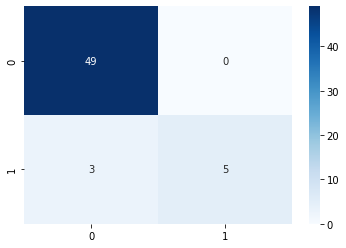

In [ ]:
sn.heatmap(evt_confusion_mat, annot=True, cmap='Blues')

In [ ]:
evt_True_positives,evt_False_negatives,evt_False_positives,evt_True_negatives = evt_confusion_mat.ravel()
print("True positives: ", evt_True_positives)
print("True negatives: ", evt_True_negatives)
print("False positives: ", evt_False_positives)
print("False negatives: ", evt_False_negatives)


True positives:  49
True negatives:  5
False positives:  3
False negatives:  0


In [ ]:
evt_accuracy = (evt_True_positives+evt_True_negatives)/(evt_True_positives+evt_True_negatives+evt_False_positives+evt_False_negatives)
evt_accuracy

0.9473684210526315

In [ ]:
evt_sensitivity = evt_True_positives/(evt_True_positives+evt_False_negatives) #Sn
evt_sensitivity

1.0

In [ ]:
evt_specificity = evt_True_negatives/(evt_True_negatives+evt_False_positives) #Sp
evt_specificity

0.625

In [ ]:
evt_positive_predictive_value = evt_True_positives/(evt_True_positives+evt_False_positives)
evt_positive_predictive_value

0.9423076923076923

In [ ]:
evt_negative_predictive_value = evt_True_negatives/(evt_True_negatives+evt_False_negatives)
evt_negative_predictive_value

1.0

In [ ]:
evt_relationship_index = abs(evt_specificity-evt_sensitivity)/(evt_specificity+evt_sensitivity)
evt_relationship_index

0.23076923076923078

In [ ]:
evt_P = evt_specificity*(49/len(test)) + evt_sensitivity*((len(test) - 49)/len(test))
evt_OP = evt_P-evt_relationship_index
evt_OP

0.4468623481781376

In [ ]:
evt_cc_numerator = evt_True_positives*evt_True_negatives - evt_False_positives*evt_False_negatives
evt_cc_denominator = math.sqrt(51*(evt_True_positives+evt_False_positives)*((100-anomaly_image)-51)*(evt_True_negatives+evt_False_negatives))
evt_corr_coefficient = evt_cc_numerator/evt_cc_denominator
evt_corr_coefficient

0.8685977441985139

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
classificationReport = classification_report(df_Forecasted_Series['Actual_Class'], evt_forecastedError_df['Predicted_Class'])
print(classificationReport)

              precision    recall  f1-score   support

     Anomaly       0.86      1.00      0.92        49
      Normal       0.00      0.00      0.00         8

    accuracy                           0.86        57
   macro avg       0.43      0.50      0.46        57
weighted avg       0.74      0.86      0.79        57



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


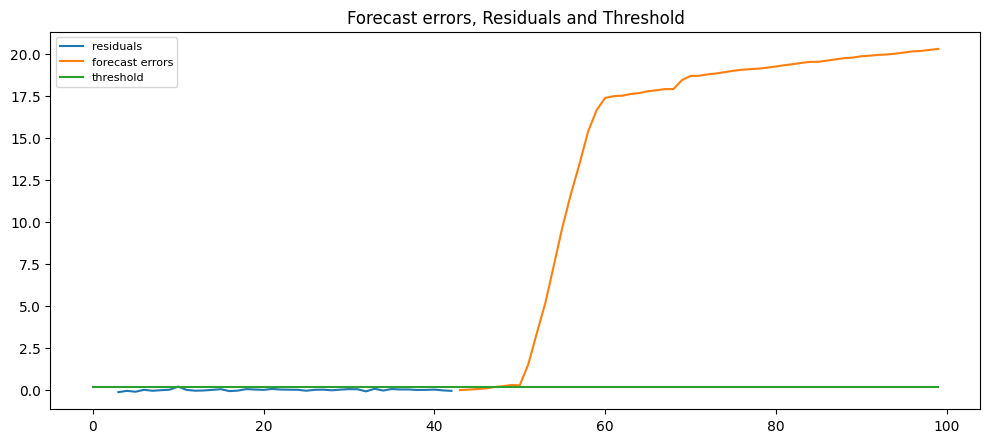

In [ ]:
evt_threshold_series = np.full((100,1), evt_threshold)
forecast_error_series = df_Forecasted_Series["Forecasted_Error"]
plt.figure(figsize=(12,5), dpi=100)
plt.plot(residuals[(number_of_diffs+1):], label='residuals')
plt.plot(forecast_error_series, label='forecast errors')
plt.plot(evt_threshold_series, label='threshold')
plt.title('Forecast errors, Residuals and Threshold')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
evt_end_time = time.time()

In [ ]:
time_evt = evt_end_time - evt_start_time
time_evt

0.8865764141082764

In [ ]:

evt_threshold = anomaly_threshold_evt(np.array(residuals[(number_of_diffs+1):]), 0.60)

In [ ]:
def classifyData(threshold, df):
  index = df.index
  for i in index:
    error = df["Forecasted_Error"].loc[i]
    #Classify residuals as normal/anomaly
    if (error>threshold):
      df.loc[i, 'Predicted_Class'] = "Anomaly"
    else:
      df.loc[i, 'Predicted_Class'] = "Normal"

    #Set the actual class
    if(i>=1997):
      df.loc[i, 'Actual_Class'] = "Anomaly"
    else:
      df.loc[i, 'Actual_Class'] = "Normal"

In [ ]:
evt_forecastedError_df = df_Forecasted_Series
print(evt_forecastedError_df)
classifyData(evt_threshold, evt_forecastedError_df)
evt_forecastedError_df

    Forecasted_Error Predicted_Class Actual_Class
43         -0.015271          Normal       Normal
44          0.008359         Anomaly       Normal
45          0.042854         Anomaly       Normal
46          0.077549         Anomaly       Normal
47          0.159146         Anomaly       Normal
48          0.214779         Anomaly       Normal
49          0.283466         Anomaly       Normal
50          0.263032         Anomaly       Normal
51          1.518479         Anomaly      Anomaly
52          3.373028         Anomaly      Anomaly
53          5.180055         Anomaly      Anomaly
54          7.427912         Anomaly      Anomaly
55          9.696519         Anomaly      Anomaly
56         11.678929         Anomaly      Anomaly
57         13.460502         Anomaly      Anomaly
58         15.374848         Anomaly      Anomaly
59         16.657062         Anomaly      Anomaly
60         17.386735         Anomaly      Anomaly
61         17.492646         Anomaly      Anomaly


,Forecasted_Error,Predicted_Class,Actual_Class
43,-0.015271,Normal,Normal
44,0.008359,Anomaly,Normal
45,0.042854,Anomaly,Normal
46,0.077549,Anomaly,Normal
47,0.159146,Anomaly,Normal
48,0.214779,Anomaly,Normal
49,0.283466,Anomaly,Normal
50,0.263032,Anomaly,Normal
51,1.518479,Anomaly,Normal
52,3.373028,Anomaly,Normal


In [ ]:
evt_confusion_mat = confusion_matrix(df_Forecasted_Series['Actual_Class'], evt_forecastedError_df['Predicted_Class'])
evt_confusion_mat

array([[ 0,  0],
       [56,  1]])

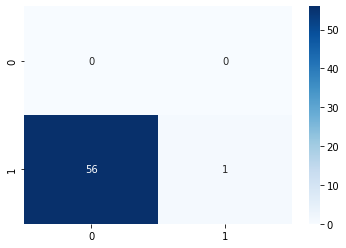

In [ ]:
sn.heatmap(evt_confusion_mat, annot=True, cmap='Blues')

In [ ]:
evt_True_negatives,evt_False_positives,evt_False_negatives,evt_True_positives = evt_confusion_mat.ravel()
print("True negatives: ", evt_True_negatives)
print("False positives: ", evt_False_positives)
print("False negatives: ", evt_False_negatives)
print("True positives: ", evt_True_positives)

True negatives:  0
False positives:  0
False negatives:  56
True positives:  1


In [ ]:
evt_accuracy = (evt_True_positives+evt_True_negatives)/(evt_True_positives+evt_True_negatives+evt_False_positives+evt_False_negatives)
evt_accuracy

0.017543859649122806